# Final Exam BUS 458 — Loan Data Analysis
**Objective:** Your objective is to identify the key drivers of loan approval and recommend which lender should be prioritized for each customer to maximize total payout

### **Instructions**
- Follow the prompts in each section of this notebook.
- **Where you see a “Question,” answer it directly below in a Markdown (text) cell — not as a code comment.**
- Your **reasoning, interpretations, and insights** should be written in text cells, clearly separated from code.
- You are encouraged to add extra **code cells**, **visualizations**, or **short explanations** if they strengthen your analysis or help you justify decisions.
- Make sure your notebook runs cleanly from start to finish without errors.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Load Data (via Google Drive or direct upload)

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Check first 5 rows of dataframe
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/BUS 458 Lectures /loan_data_analysis_final.csv')
display(df.head())

,User ID,applications,Reason,Granted_Loan_Amount,Requested_Loan_Amount,FICO_score,Fico_Score_group,Employment_Status,Employment_Sector,Monthly_Gross_Income,Monthly_Housing_Payment,Ever_Bankrupt_or_Foreclose,Lender,Approved,bounty
0,00007820-89cb-4c1d-9940-eb270d605a35,1,cover_an_unexpected_cost,100000,123000.0,669.0,fair,full_time,consumer_discretionary,5024.0,927,0,B,0,0
1,00012b55-514c-421e-9c76-3300abbc1134,1,credit_card_refinancing,70000,79000.0,594.0,fair,full_time,information_technology,5764.0,1177,0,B,0,0
2,000157c1-b6a3-4c86-82c7-9ec1bda3799a,1,home_improvement,10000,11000.0,596.0,fair,full_time,information_technology,4017.0,1487,0,A,0,0
3,00020400-efab-4b10-8812-2a0aaf774841,1,home_improvement,100000,120000.0,642.0,fair,part_time,energy,3129.0,904,0,A,0,0
4,0002f737-0cda-48fb-91ed-533f3d0eab05,1,major_purchase,30000,34000.0,NaN,fair,full_time,energy,NaN,1620,0,A,0,0


In [19]:
# Drop columns that have no variation or are unique
df_original = df.copy() # Make a copy before dropping columns, if needed for later stages

# Identify columns with no variation (constant columns)
constant_cols = [col for col in df.columns if df[col].nunique() == 1]

# Identify columns where all values are unique (potential ID columns)
unique_cols = [col for col in df.columns if df[col].nunique() == len(df)]

# Combine the lists of columns to drop, ensuring no duplicates
columns_to_drop = list(set(constant_cols + unique_cols))

# Drop the identified columns from the DataFrame
df = df.drop(columns=columns_to_drop)

print(f"Dropped {len(constant_cols)} constant column(s): {constant_cols}")
print(f"Dropped {len(unique_cols)} unique column(s): {unique_cols}")
print(f"New DataFrame shape: {df.shape}")

Dropped 1 constant column(s): ['applications']
Dropped 1 unique column(s): ['User ID']
New DataFrame shape: (100000, 13)


Understand the Data: Get a quick overview of the dataset structure and variable meanings before preprocessing.

In [20]:
df.info()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Reason                      100000 non-null  object 
 1   Granted_Loan_Amount         100000 non-null  int64  
 2   Requested_Loan_Amount       100000 non-null  float64
 3   FICO_score                  85000 non-null   float64
 4   Fico_Score_group            100000 non-null  object 
 5   Employment_Status           100000 non-null  object 
 6   Employment_Sector           93593 non-null   object 
 7   Monthly_Gross_Income        85000 non-null   float64
 8   Monthly_Housing_Payment     100000 non-null  int64  
 9   Ever_Bankrupt_or_Foreclose  100000 non-null  int64  
 10  Lender                      100000 non-null  object 
 11  Approved                    100000 non-null  int64  
 12  bounty                      100000 non-null  int64  
dtypes: float64(3), 

,Granted_Loan_Amount,Requested_Loan_Amount,FICO_score,Monthly_Gross_Income,Monthly_Housing_Payment,Ever_Bankrupt_or_Foreclose,Approved,bounty
count,1.000000e+05,1.000000e+05,85000.000000,85000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,6.478465e+04,7.450309e+04,629.338153,5808.783776,1888.900720,0.022460,0.109760,26.415000
std,1.965837e+05,2.264856e+05,88.684201,2988.185274,3431.924282,0.148175,0.312592,78.385644
min,5.000000e+03,5.000000e+03,300.000000,-17702.000000,300.000000,0.000000,0.000000,0.000000
25%,2.000000e+04,2.400000e+04,572.000000,3659.000000,1231.000000,0.000000,0.000000,0.000000
50%,4.000000e+04,4.400000e+04,634.000000,5153.500000,1669.000000,0.000000,0.000000,0.000000
75%,7.000000e+04,8.400000e+04,693.000000,7612.000000,2051.000000,0.000000,0.000000,0.000000
max,2.000000e+06,2.500000e+06,850.000000,19997.000000,49500.000000,1.000000,1.000000,350.000000


## 1. Preprocessing


### 1.1 Handling Missing Values

**Question:** Why is median imputation often preferable to mean imputation for income and FICO?


**Answer:** Add your answer here





In [21]:
# Inspect missing values
missing_values = df.isnull().sum()
missing_percentage = 100 * df.isnull().sum() / len(df)
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
display(missing_df[missing_df['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False))

,Missing Values,Percentage
FICO_score,15000,15.000
Monthly_Gross_Income,15000,15.000
Employment_Sector,6407,6.407


In [22]:
# Apply imputation as instructed in the instructions pdf (create copies so original rows can be restored if needed)

df['FICO_score'] = df['FICO_score'].fillna(df['FICO_score'].median())

df['Monthly_Gross_Income'] = df['Monthly_Gross_Income'].fillna(df['Monthly_Gross_Income'].median())

df['Employment_Sector'] = df['Employment_Sector'].fillna('Unknown')

print("Missing values after imputation:")
print(df.isnull().sum())

Missing values after imputation:
Reason                        0
Granted_Loan_Amount           0
Requested_Loan_Amount         0
FICO_score                    0
Fico_Score_group              0
Employment_Status             0
Employment_Sector             0
Monthly_Gross_Income          0
Monthly_Housing_Payment       0
Ever_Bankrupt_or_Foreclose    0
Lender                        0
Approved                      0
bounty                        0
dtype: int64


In [23]:
df.isnull().sum()

,0
Reason,0
Granted_Loan_Amount,0
Requested_Loan_Amount,0
FICO_score,0
Fico_Score_group,0
Employment_Status,0
Employment_Sector,0
Monthly_Gross_Income,0
Monthly_Housing_Payment,0
Ever_Bankrupt_or_Foreclose,0


### 1.2 Outliers Detection and Removal

**Question:**
Which features had the most outliers, and what impact could they have on the model?

**Answer** : The feature that has the most outliers is Ever_bankrupt_or_foreclose with 2,246 outliers. Monthly

In [24]:
# Remove Outliers using Z-score

from scipy import stats
import numpy as np

# Define numeric columns for outlier detection
numeric_cols = ['Granted_Loan_Amount', 'Requested_Loan_Amount', 'FICO_score', 'Monthly_Gross_Income', 'Monthly_Housing_Payment']

# Compute Z-scores for only numeric columns
z_scores = np.abs(stats.zscore(df[numeric_cols], nan_policy='omit'))

# Choose threshold
threshold = 3  # common choice: 3 standard deviations

# Identify rows to keep (all Z-scores <= threshold)
rows_to_keep = (z_scores < threshold).all(axis=1)

# Track counts before/after
before_count = df.shape[0]
df_clean = df[rows_to_keep].copy()
after_count = df_clean.shape[0]

print(f"Outlier removal complete:")
print(f"Rows before: {before_count}")
print(f"Rows after:  {after_count}")
print(f"Rows removed: {before_count - after_count}")

Outlier removal complete:
Rows before: 100000
Rows after:  95691
Rows removed: 4309


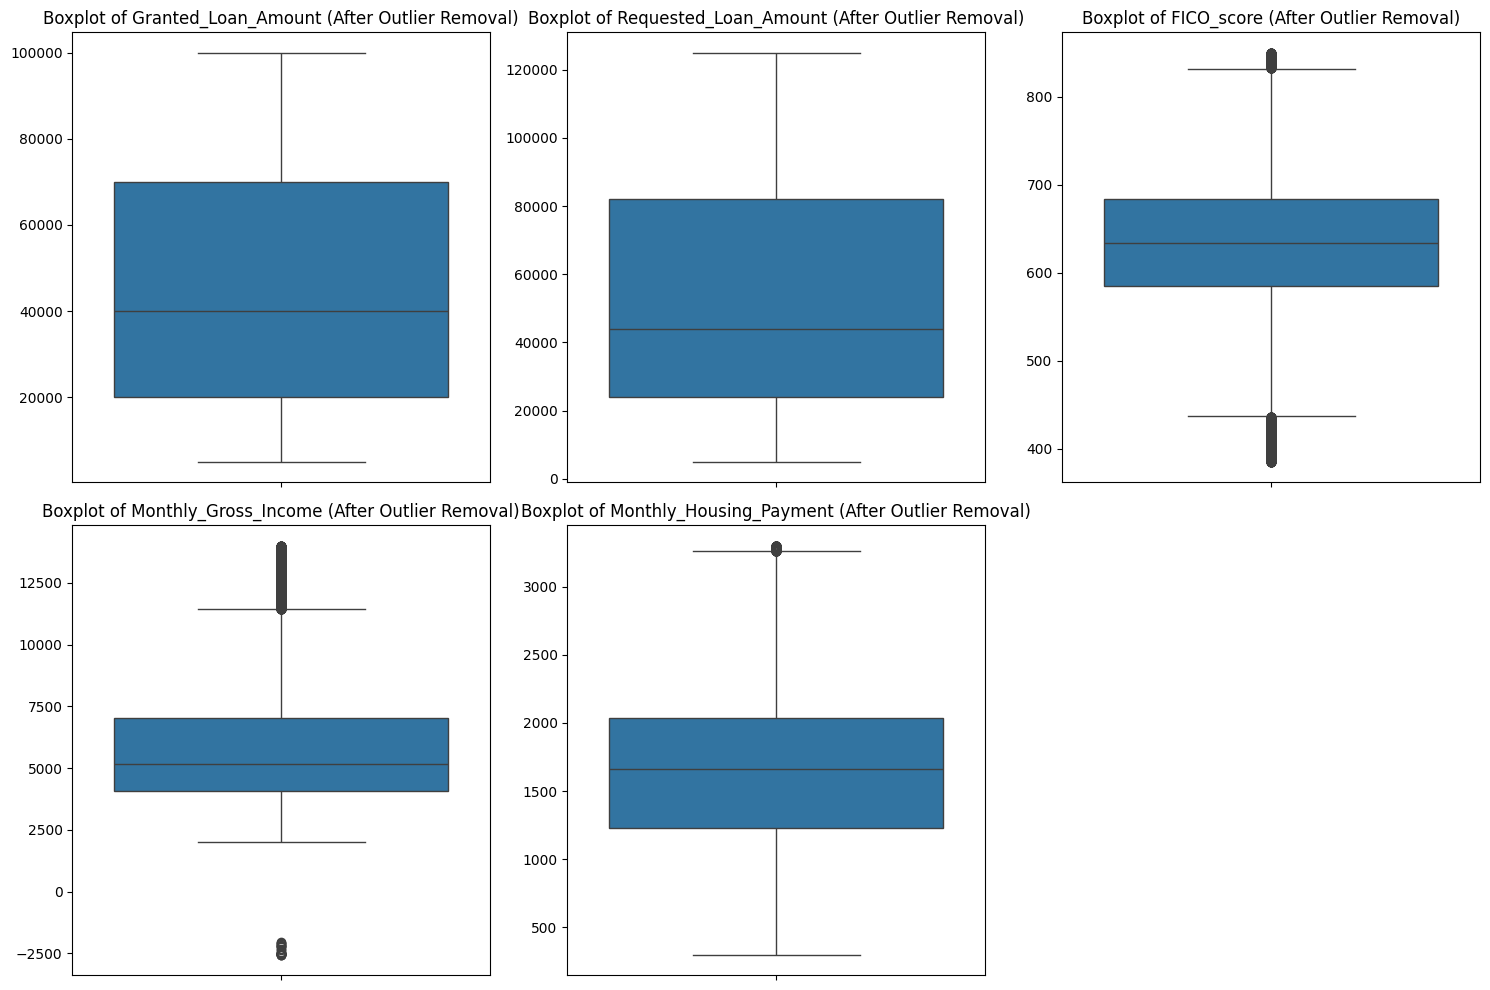

In [25]:
# BoxPlots after outlier removal
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ['Granted_Loan_Amount', 'Requested_Loan_Amount', 'FICO_score', 'Monthly_Gross_Income', 'Monthly_Housing_Payment']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df_clean[col])
    plt.title(f'Boxplot of {col} (After Outlier Removal)')
    plt.ylabel('')
plt.tight_layout()
plt.show()

**Question:**
Why do we need to remove or treat outliers? Provide reasoning based on model performance or data integrity.

**Answer** : Add your answer here


**Question:**
Is there a difference between boxplots before and after outlier removal?

**Answer** : Add your answer here

### 1.3 Redundancy & Correlation Check (5 Marks)

Detect duplicate data and multicollinearity.

**Question:**
Which numerical variables appear most strongly correlated with each other?

**Answer:** Add your answer here



**Question:**
Which numerical and categorical are strongly corelated to each other?

**Answer:** Add your answer here


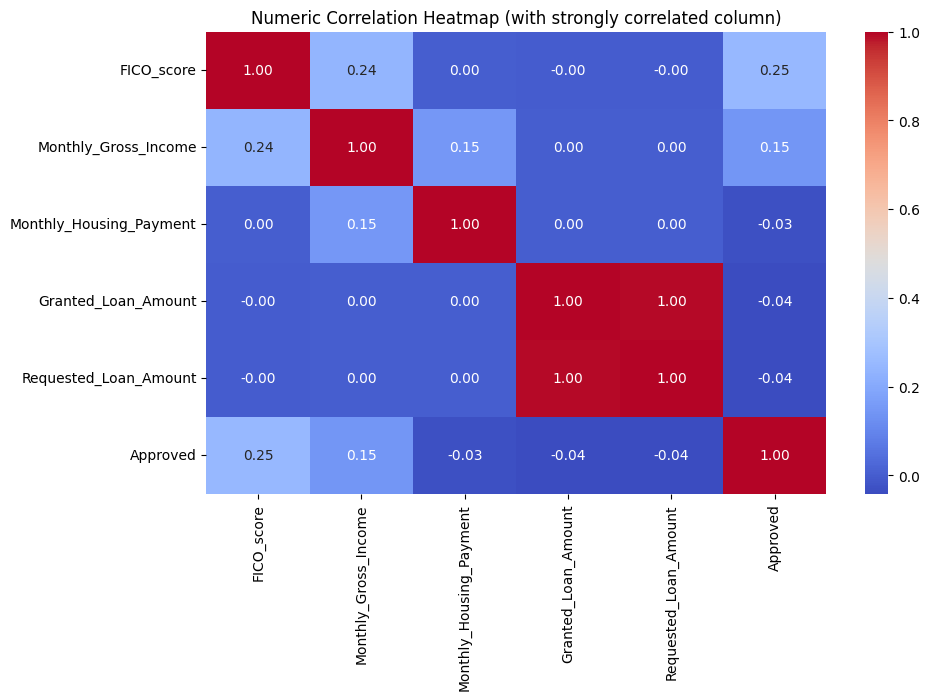

Highly correlated pairs (|corr| > 0.95):
Granted_Loan_Amount  <-->  Requested_Loan_Amount   (corr = 1.00)


In [26]:
# Correlation between numerical features
numeric_cols = ['FICO_score', 'Monthly_Gross_Income', 'Monthly_Housing_Payment', 'Granted_Loan_Amount','Requested_Loan_Amount', 'Approved']

# Plot correlation matrix, identify highly correlated pairs automatically (|corr|>0.95, excluding self-correlation)
corr = df_clean[numeric_cols].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Numeric Correlation Heatmap (with strongly correlated column)")
plt.show()

high_corr_pairs = []

for col1 in corr.columns:
    for col2 in corr.columns:
        if col1 != col2:
            corr_val = corr.loc[col1, col2]
            if abs(corr_val) > 0.95:
                high_corr_pairs.append((col1, col2, corr_val))

unique_pairs = []
seen = set()
for a, b, c in high_corr_pairs:
    pair = tuple(sorted([a, b]))
    if pair not in seen:
        unique_pairs.append((a, b, c))
        seen.add(pair)

print("Highly correlated pairs (|corr| > 0.95):")
for a, b, c in unique_pairs:
    print(f"{a}  <-->  {b}   (corr = {c:.2f})")


Top 10 Numeric-Categorical Correlation Ratios (η²):
FICO_score - Fico_Score_group: η² = 0.729 (η = 0.854)
Monthly_Gross_Income - Employment_Status: η² = 0.246 (η = 0.496)
Monthly_Gross_Income - Fico_Score_group: η² = 0.074 (η = 0.272)
Monthly_Gross_Income - Employment_Sector: η² = 0.070 (η = 0.265)
Monthly_Housing_Payment - Employment_Status: η² = 0.039 (η = 0.198)
Ever_Bankrupt_or_Foreclose - Employment_Status: η² = 0.030 (η = 0.174)
Monthly_Housing_Payment - Lender: η² = 0.028 (η = 0.169)
Ever_Bankrupt_or_Foreclose - Employment_Sector: η² = 0.026 (η = 0.162)
Monthly_Gross_Income - Lender: η² = 0.008 (η = 0.090)
Ever_Bankrupt_or_Foreclose - Lender: η² = 0.005 (η = 0.071)


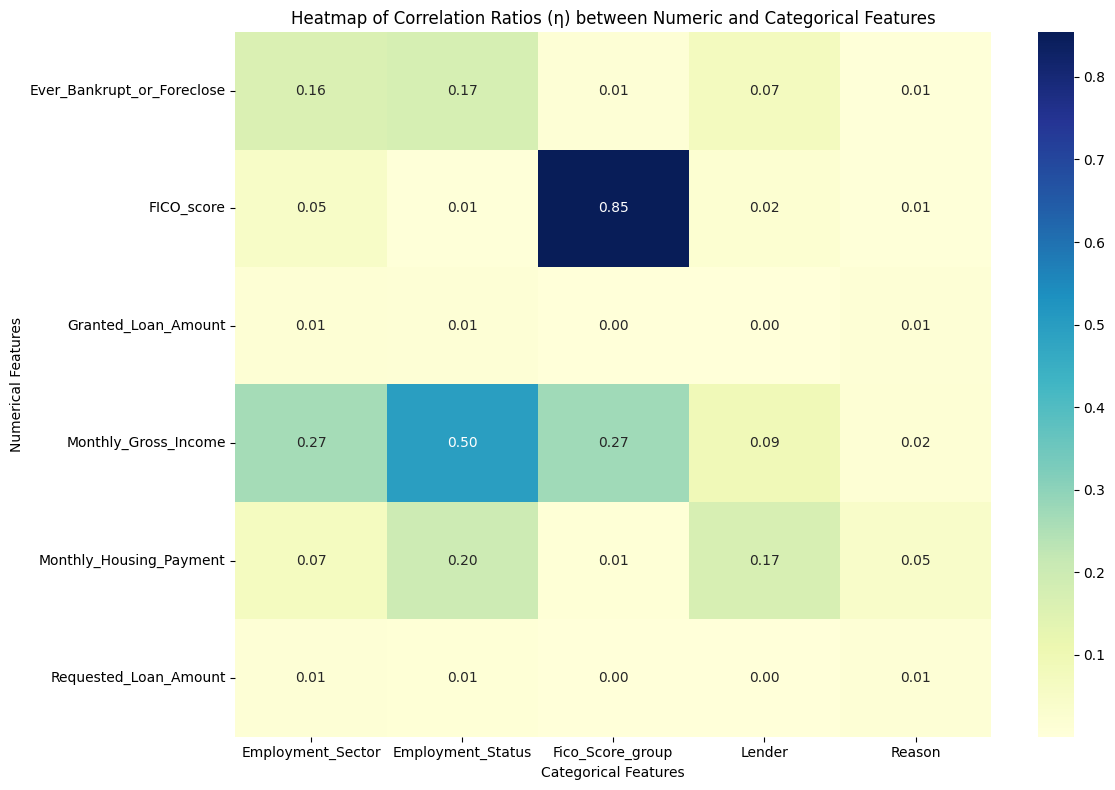

In [27]:
# Correlation between Numeric and Categorical Variables (Correlation Ratio / η²)
from scipy import stats

def correlation_ratio(categories, values):
    categories = np.array(categories)
    values = np.array(values)
    cat_levels = np.unique(categories)
    overall_mean = np.mean(values)
    numerator = sum(len(values[categories == cat]) *
                    (np.mean(values[categories == cat]) - overall_mean) ** 2
                    for cat in cat_levels)
    denominator = sum((values - overall_mean) ** 2)
    return np.sqrt(numerator / denominator) if denominator != 0 else 0

# test all numeric–categorical pairs
num_cat_results = []


# Identify categorical and numerical columns
categorical_cols_clean = df_clean.select_dtypes(include='object').columns.tolist()
numeric_cols_clean = df_clean.select_dtypes(include=np.number).columns.tolist()


numeric_cols_for_eta = [col for col in numeric_cols_clean if col not in ['bounty', 'Approved', ]]
categorical_cols_for_eta = [col for col in categorical_cols_clean]


for num_col in numeric_cols_for_eta:
    for cat_col in categorical_cols_for_eta:
        eta = correlation_ratio(df_clean[cat_col], df_clean[num_col])
        num_cat_results.append((num_col, cat_col, eta))

num_cat_results = sorted(num_cat_results, key=lambda x: x[2], reverse=True)
print("Top 10 Numeric-Categorical Correlation Ratios (η²):")
for num_col, cat_col, eta in num_cat_results[:10]:
    print(f"{num_col} - {cat_col}: η² = {eta**2:.3f} (η = {eta:.3f})")


# Reorganize the correlation ratio results into a pivot table/matrix for heatmap
eta_matrix = pd.DataFrame(num_cat_results, columns=['Numerical_Feature', 'Categorical_Feature', 'Eta'])
eta_pivot = eta_matrix.pivot(index='Numerical_Feature', columns='Categorical_Feature', values='Eta')

# Plot the heatmap of correlation ratios (Eta)
plt.figure(figsize=(12, 8))
sns.heatmap(eta_pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Heatmap of Correlation Ratios (η) between Numeric and Categorical Features")
plt.xlabel("Categorical Features")
plt.ylabel("Numerical Features")
plt.tight_layout()
plt.show()



**Questions:** What features will you consider dropping after analyzing the graphs above?

**Answer** : Add your answer here



> *Note: For Decision Tree models, you do not need to remove or adjust for collinearity. The algorithm can naturally handle correlated features through its splitting mechanism. However, for Logistic Regression, multicollinearity can distort coefficient estimates and make interpretations unreliable. In that case, you may consider removing one variable from highly correlated pairs.


## 2. Exploratory Data Analysis

### 2.1 Target Variable Distribution

Analyze the distribution of the target variable (Approved) to understand class balance in loan approval outcomes.


**Question:**
Is the dataset balanced or imbalanced? Briefly explain the implication for modeling.


**Answer:**
Add your answer here

/tmp/ipython-input-2035130200.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Approved', data=df_clean, palette='viridis')


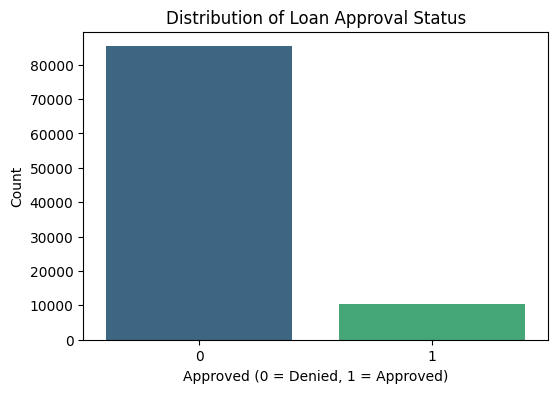

In [28]:
# Plot 'Approved' to visualise the count and balance
plt.figure(figsize=(6, 4))
sns.countplot(x='Approved', data=df_clean, palette='viridis')
plt.title('Distribution of Loan Approval Status')
plt.xlabel('Approved (0 = Denied, 1 = Approved)')
plt.ylabel('Count')
plt.show()

### 2.2 Distribution of Numerical Variables by Approval

Explore how key numerical variables differ between approved and rejected loan applications.


**Question:**
Which numerical variable is the most helpful variable ( most crucial predictor) ?

**Answer:**
Add your answer here


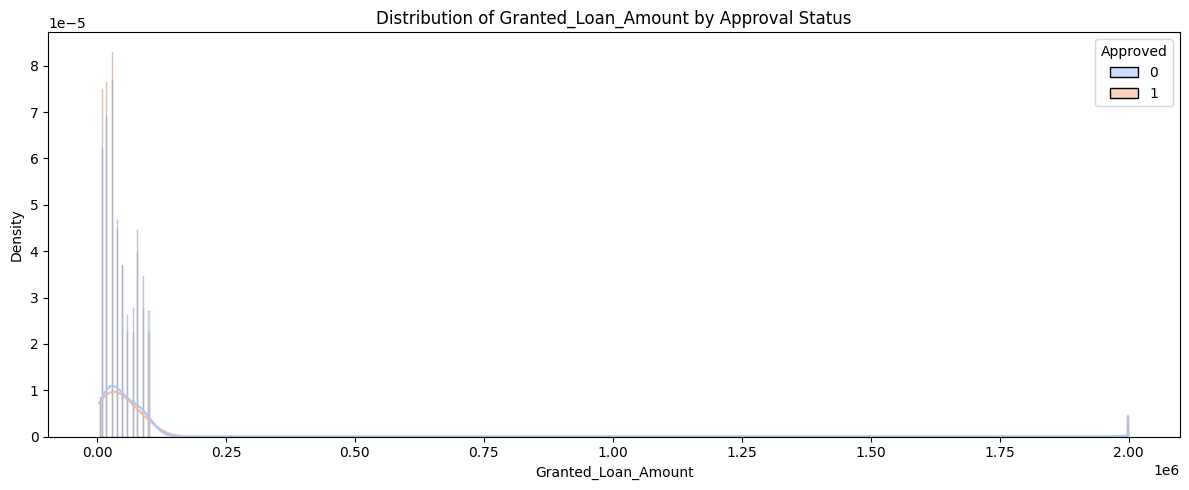

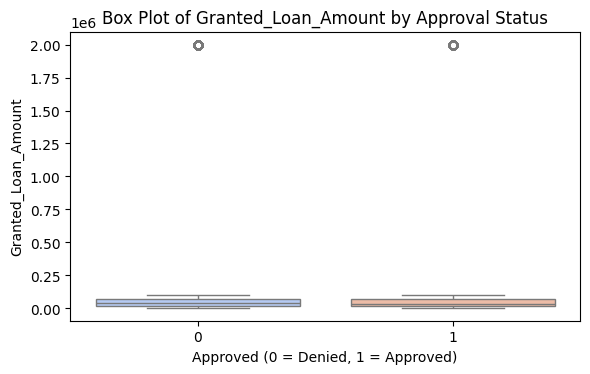

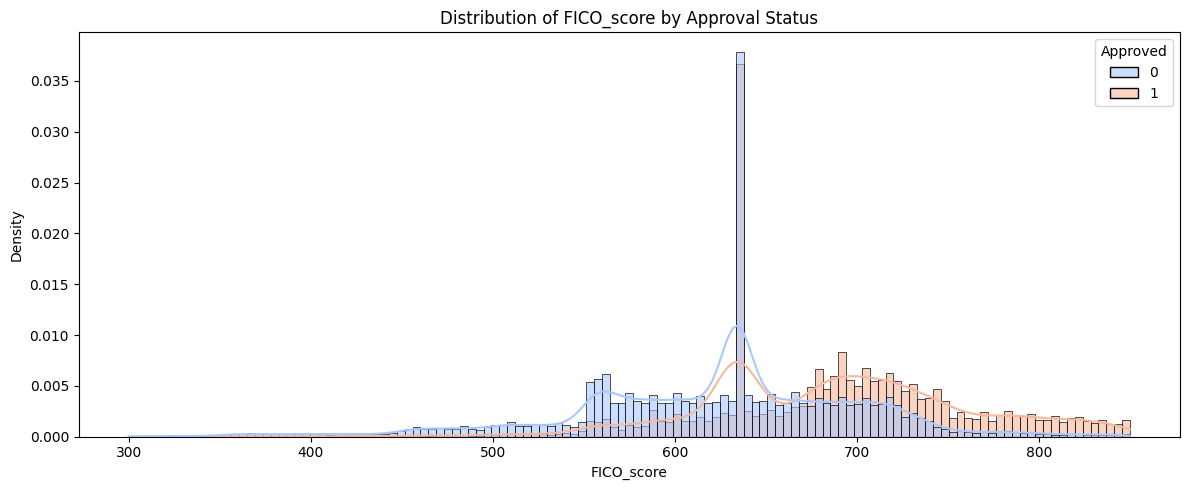

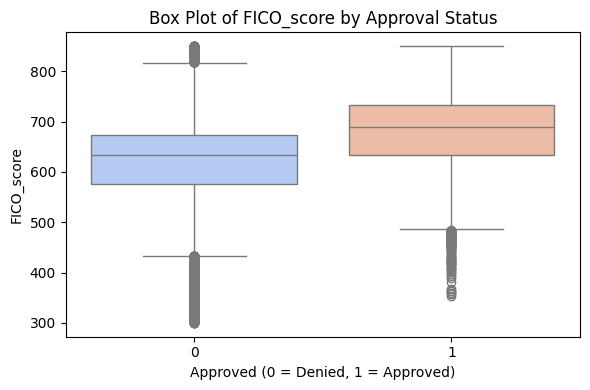

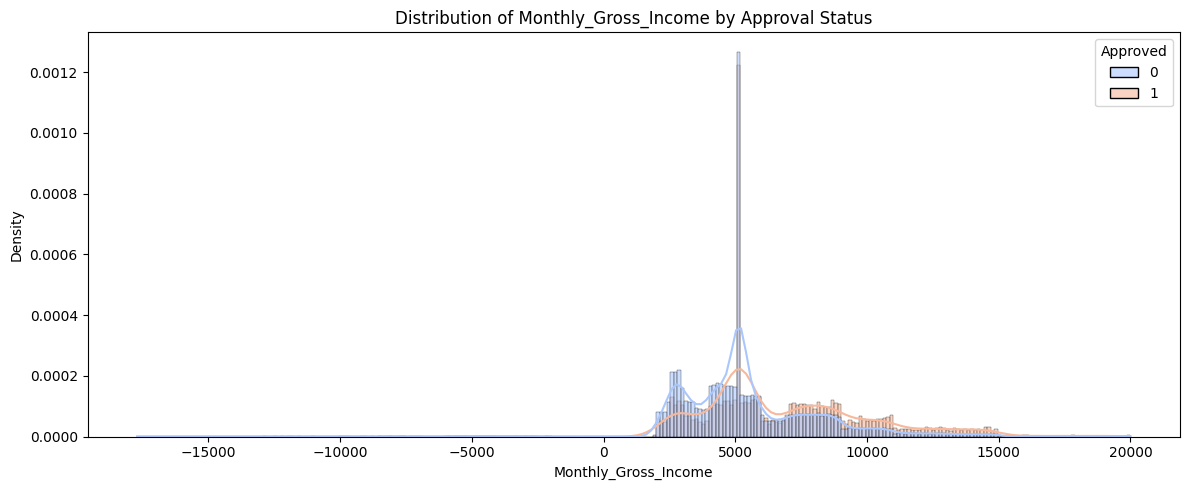

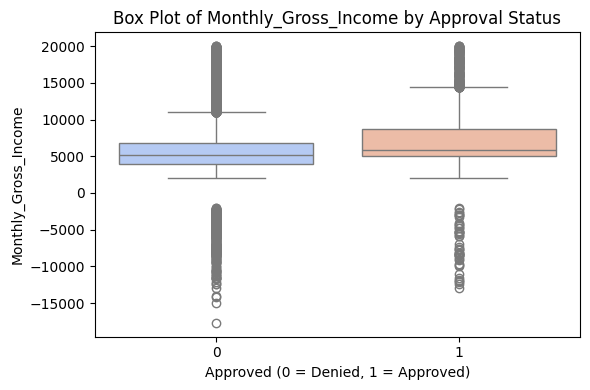

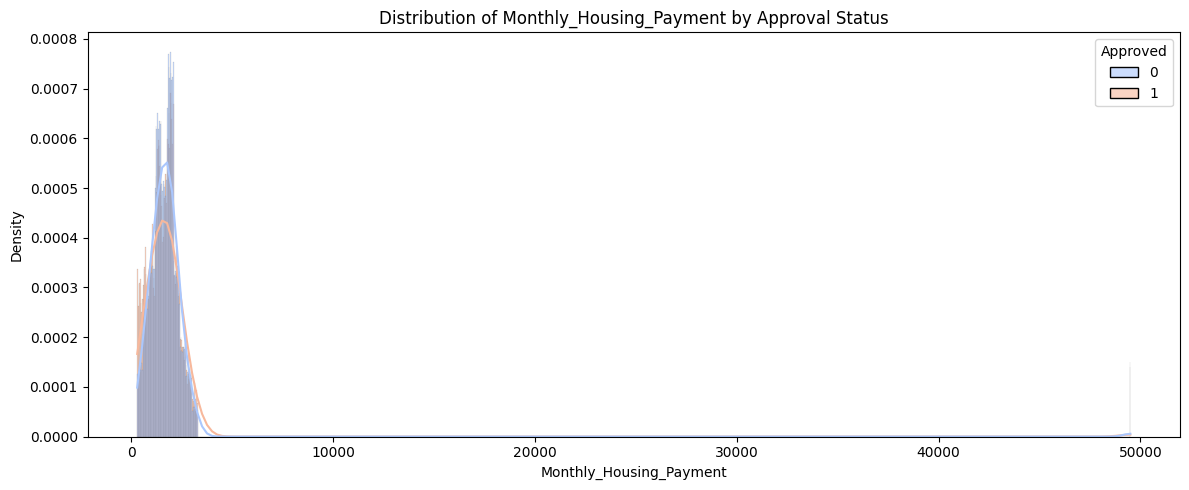

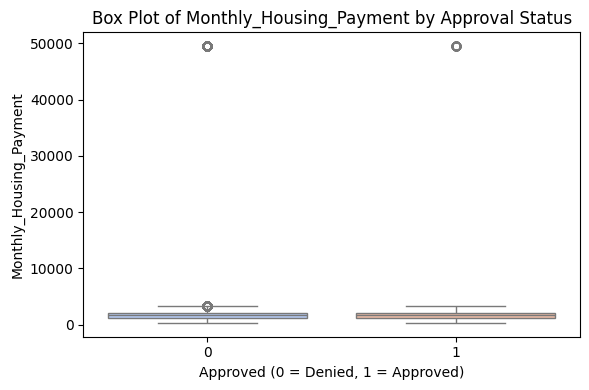

In [29]:
# Visualise numerical variables against target variable

numerical_cols = ['Granted_Loan_Amount', 'FICO_score', 'Monthly_Gross_Income', 'Monthly_Housing_Payment']

for col in numerical_cols:
    plt.figure(figsize=(12,5))
    sns.histplot(
        data=df,
        x=col,
        hue='Approved',
        kde=True,
        stat='density',
        common_norm=False,
        palette='coolwarm',
        alpha=0.6
    )
    plt.title(f'Distribution of {col} by Approval Status')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,4))
    sns.boxplot(
        data=df,
        x='Approved',
        y=col,
        hue='Approved',
        palette='coolwarm',
        legend=False
    )
    plt.title(f'Box Plot of {col} by Approval Status')
    plt.xlabel('Approved (0 = Denied, 1 = Approved)')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


### 2.3 Categorical Variables and Approval

Analyze how categorical variables (such as Employment_Sector, Loan_Purpose, or Residence_Type) relate to the loan approval outcome.


**Question:**
Which categorical variable appears to have the strongest relationship with loan approval, and how can you tell?

**Answer:**
Add your answer here


**Question:**
Are there any categories (e.g., Reason, Employment_Status) that appear to have minimal predictive value? Justify your answer with approval rate differences.

**Answer:**
Add your answer here

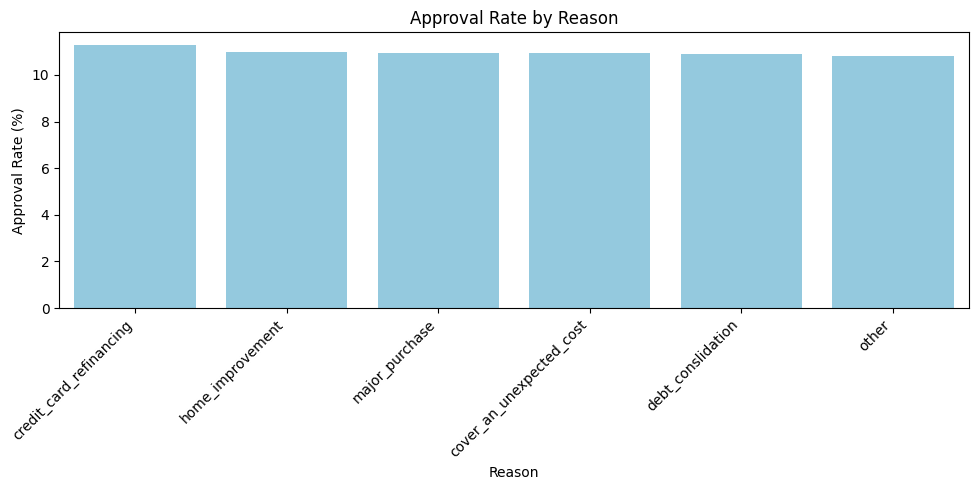


Approval Rate by Reason:
Reason
credit_card_refinancing     11.27
home_improvement            10.98
major_purchase              10.95
cover_an_unexpected_cost    10.93
debt_conslidation           10.89
other                       10.81
Name: Approved, dtype: float64


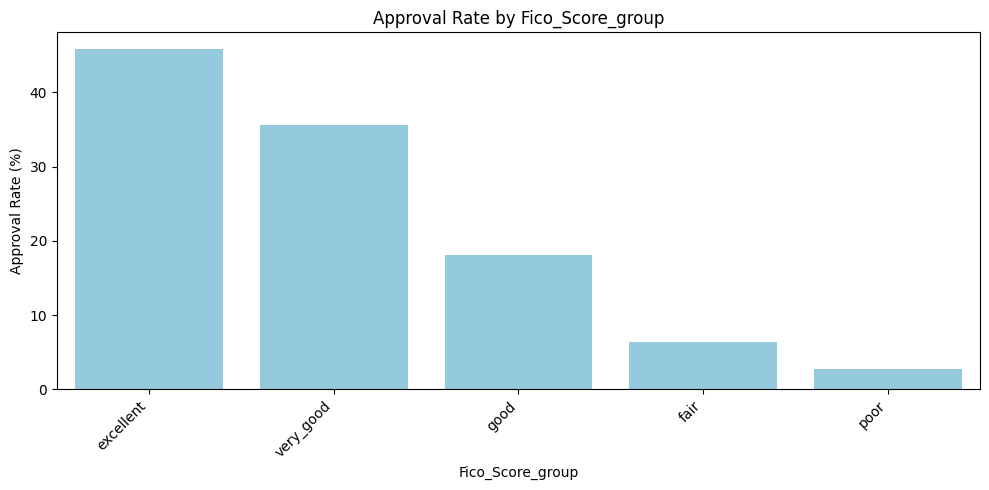


Approval Rate by Fico_Score_group:
Fico_Score_group
excellent    45.80
very_good    35.65
good         18.06
fair          6.44
poor          2.78
Name: Approved, dtype: float64


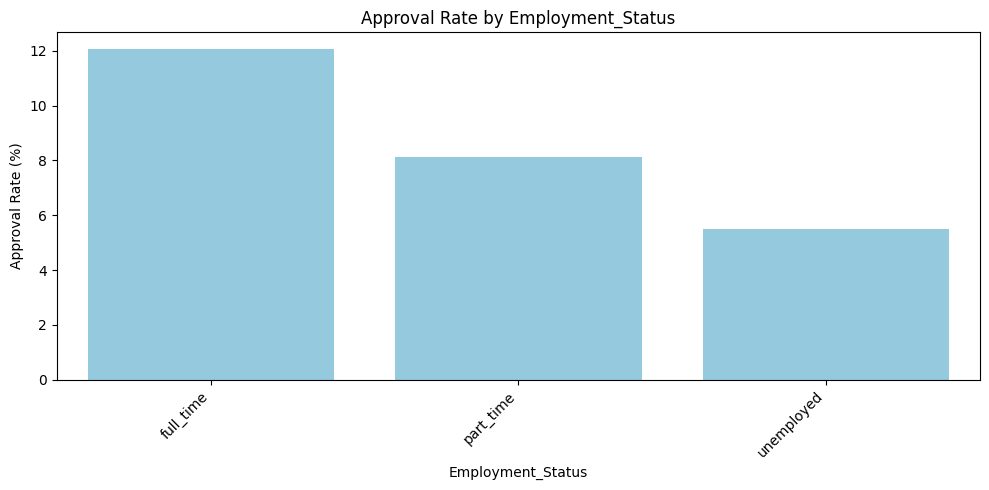


Approval Rate by Employment_Status:
Employment_Status
full_time     12.07
part_time      8.12
unemployed     5.49
Name: Approved, dtype: float64


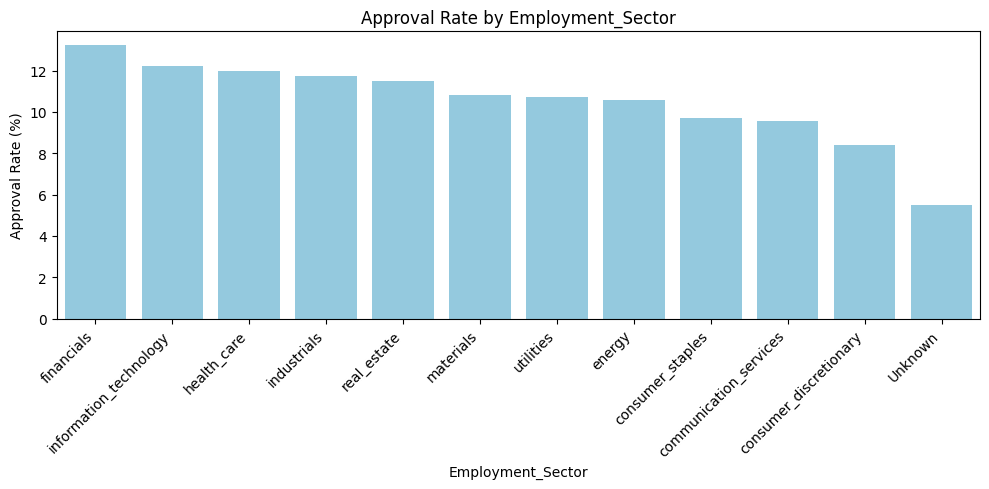


Approval Rate by Employment_Sector:
Employment_Sector
financials                13.24
information_technology    12.20
health_care               11.97
industrials               11.75
real_estate               11.50
materials                 10.83
utilities                 10.71
energy                    10.60
consumer_staples           9.68
communication_services     9.57
consumer_discretionary     8.42
Unknown                    5.49
Name: Approved, dtype: float64


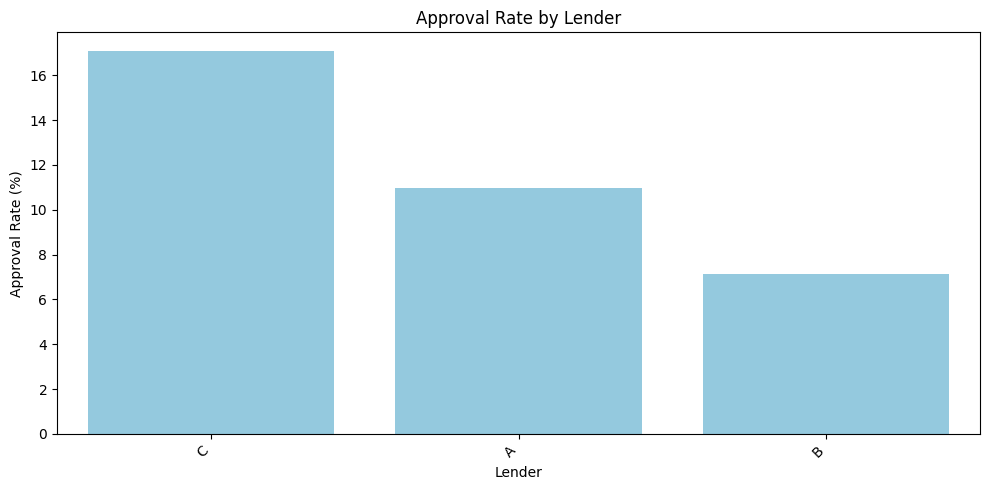


Approval Rate by Lender:
Lender
C    17.06
A    10.97
B     7.13
Name: Approved, dtype: float64


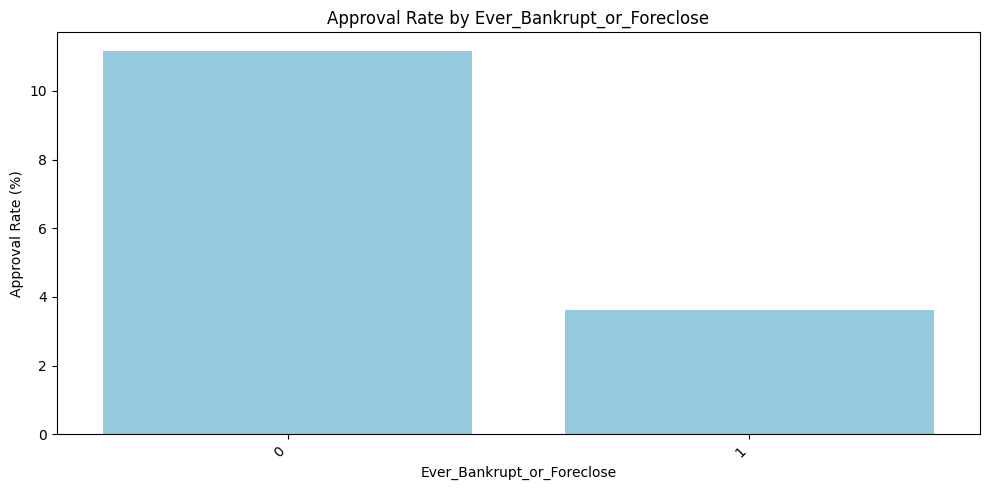


Approval Rate by Ever_Bankrupt_or_Foreclose:
Ever_Bankrupt_or_Foreclose
0    11.15
1     3.61
Name: Approved, dtype: float64


In [30]:
# Visualise categorical variables against target variable

categorical_cols = [
    'Reason', 'Fico_Score_group', 'Employment_Status',
    'Employment_Sector', 'Lender', 'Ever_Bankrupt_or_Foreclose'
]

for col in categorical_cols:
    approval_rates = df.groupby(col)['Approved'].mean().sort_values(ascending=False) * 100

    plt.figure(figsize=(10,5))
    sns.barplot(x=approval_rates.index, y=approval_rates.values, color='skyblue')
    plt.title(f'Approval Rate by {col}')
    plt.xlabel(col)
    plt.ylabel('Approval Rate (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print(f"\nApproval Rate by {col}:\n{approval_rates.round(2)}")


### Cross Feature plots for multi-dimensional analysis.

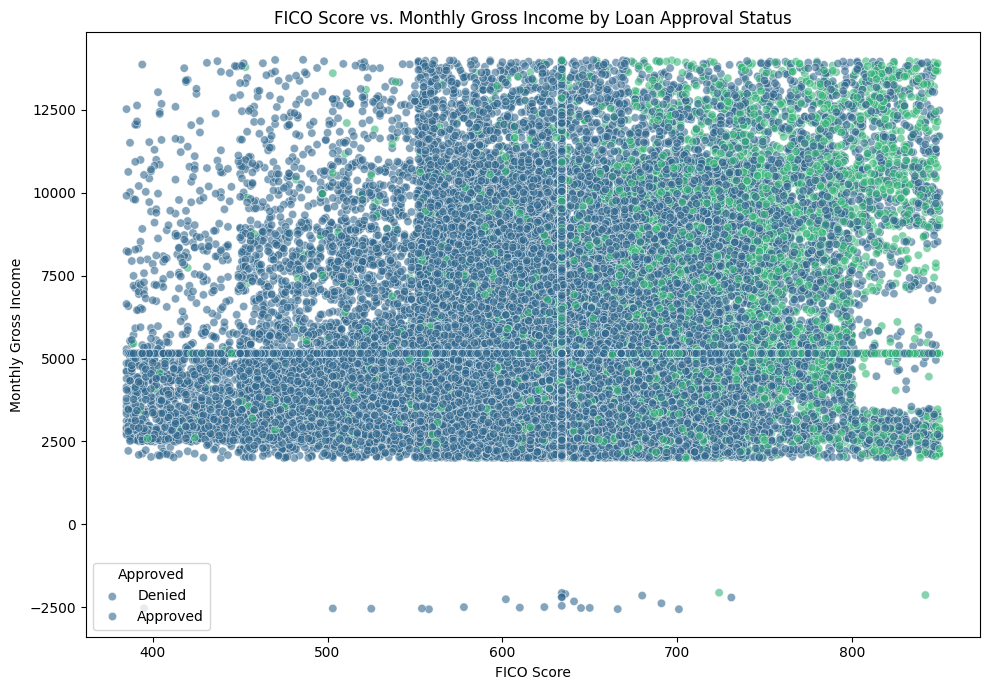

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_clean,
    x='FICO_score',
    y='Monthly_Gross_Income',
    hue='Approved',
    palette='viridis',
    alpha=0.6
)
plt.title('FICO Score vs. Monthly Gross Income by Loan Approval Status')
plt.xlabel('FICO Score')
plt.ylabel('Monthly Gross Income')
plt.legend(title='Approved', labels=['Denied', 'Approved'])
plt.tight_layout()
plt.show()

## 3.5 Business Insights from EDA

After completing your visualizations and cross-feature analyses, summarize your findings in the context of loan approval and lender matching.  
Use this section to connect data patterns to real-world meaning before building predictive models.


**Question:** Which variables are the most helpful in understanding if a customer is going to be approved or denied for a loan?  

**Answer**: Add your answer here

**Question:** Are there any feature modifications or transformations that would improve the predictive power of a variable?  

**Answer**: Add your answer here

**Question:** What is each lender’s average approval rate?  

**Answer**: Add your answer here

**Question:** Are there any clear differences between the three lenders in terms of which types of customers they approve?  

**Answer**: Add your answer here

**Question:** Are there variables that reliably predict a customer’s approval likelihood for a particular lender?  

**Answer**: Add your answer here



> Treat this section as your interpretation bridge between EDA and modeling. The goal is to show that you understand *why* certain patterns exist, not just that they exist.


## 3. Model Training

### 3.1 Train/Test Split and Encoding

In [32]:
# Split dataset into train and test
from sklearn.model_selection import train_test_split

# Rename df to df_model.
df_model = df_clean.copy() # Assign df_clean to df_model
X = df_model.drop(columns=['Approved', 'bounty'])
y = df_model['Approved'] # Define the target variable

X = pd.get_dummies(X, drop_first=True)

random_state = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

### 3.2 Logistic Regression Model
Build and interpret a Logistic Regression model to predict the likelihood of loan approval (Approved = 1).

**Question**
How accurate is the model on the test data, and what does this imply about its predictive strength?

**Answer**
Add your answer here


In [33]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression model
logistic_model = LogisticRegression(random_state=random_state, solver='liblinear', C=0.1) # C=0.1 for some regularization
logistic_model.fit(X_train, y_train)

LogisticRegression(C=0.1, random_state=42, solver='liblinear')

Logistic Regression Model Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     17063
           1       1.00      0.00      0.00      2076

    accuracy                           0.89     19139
   macro avg       0.95      0.50      0.47     19139
weighted avg       0.90      0.89      0.84     19139


ROC-AUC Score: 0.5420


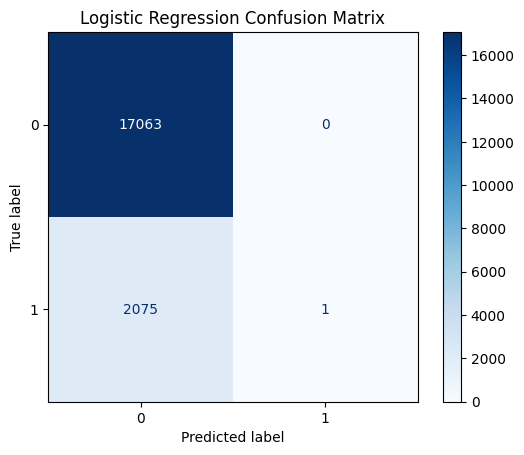

In [34]:
# Evaluate the Model
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_logistic = logistic_model.predict(X_test)
y_prob_logistic = logistic_model.predict_proba(X_test)[:, 1]

print("Logistic Regression Model Evaluation:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logistic))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_prob_logistic):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_logistic)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logistic_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')
plt.show()

### 3.2 Decision Tree Classifier Model

Build and interpret a Decision Tree Classifier Model to predict the likelihood of loan approval (Approved = 1).



**Question**
How does the Decision Tree’s accuracy and AUC compare to the Logistic Regression model?

**Answer**
Add your answer here


In [35]:
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=random_state)
decision_tree_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

Decision Tree Model Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     17063
           1       0.24      0.27      0.26      2076

    accuracy                           0.83     19139
   macro avg       0.58      0.58      0.58     19139
weighted avg       0.84      0.83      0.83     19139


ROC-AUC Score: 0.5841


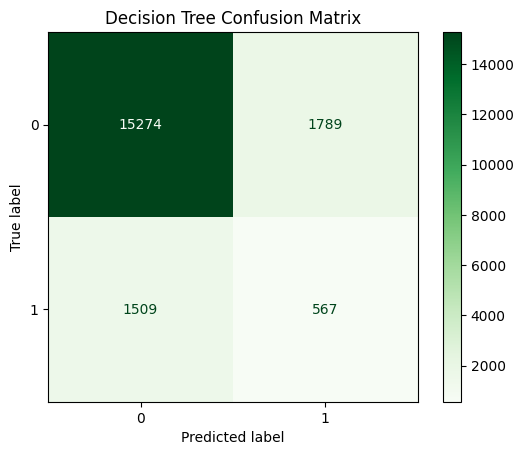

In [36]:
# Evaluate the model
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_tree = decision_tree_model.predict(X_test)
y_prob_tree = decision_tree_model.predict_proba(X_test)[:, 1]

print("Decision Tree Model Evaluation:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tree))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_prob_tree):.4f}")

# Confusion Matrix
cm_tree = confusion_matrix(y_test, y_pred_tree)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=decision_tree_model.classes_)
disp_tree.plot(cmap=plt.cm.Greens)
plt.title('Decision Tree Confusion Matrix')
plt.show()

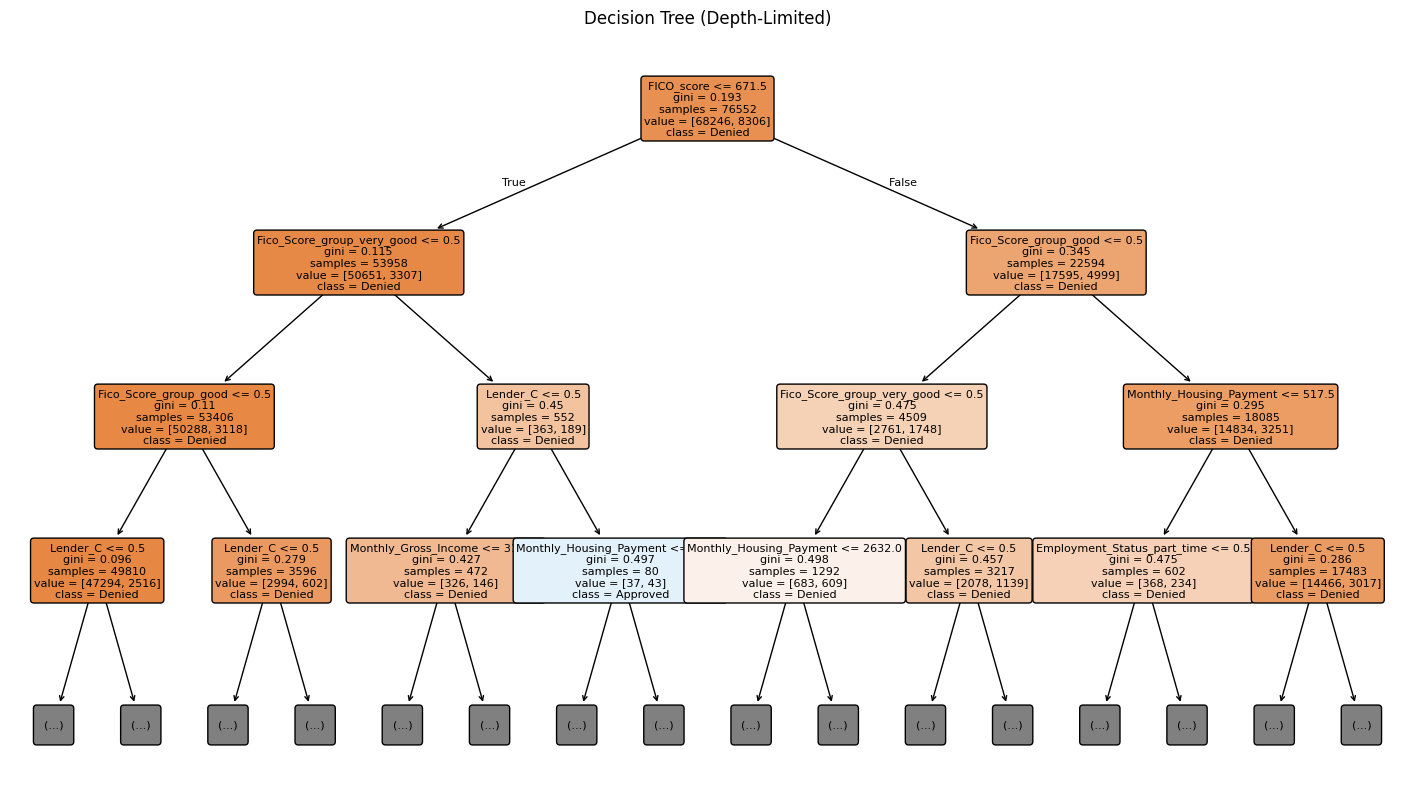

In [37]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))
plot_tree(
    decision_tree_model,
    max_depth=3,
    filled=True,
    feature_names=X.columns.tolist(),
    class_names=['Denied', 'Approved'],
    rounded=True,
    fontsize=8
)
plt.title('Decision Tree (Depth-Limited)')
plt.show()

In [38]:
# Variable importance for Decision Tree
# Print top features
feature_importances = decision_tree_model.feature_importances_
features = X_train.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Top features for Decision Tree:")
print(importance_df.head(10))


Top features for Decision Tree:
                                     Feature  Importance
4                    Monthly_Housing_Payment    0.213105
3                       Monthly_Gross_Income    0.178005
2                                 FICO_score    0.174690
1                      Requested_Loan_Amount    0.118428
0                        Granted_Loan_Amount    0.040874
12                     Fico_Score_group_good    0.027258
24  Employment_Sector_information_technology    0.017502
9                      Reason_major_purchase    0.017092
7                   Reason_debt_conslidation    0.016169
6             Reason_credit_card_refinancing    0.014780


## Compare the performance of the Logistic Regression and Decision Tree models.


1.   Compare the performance of the Logistic Regression and Decision Tree
models.
2.   Evaluate and compare both models using key metrics such as ROC-AUC, Accuracy, Precision, Recall, and F1-score.
3. Plot and interpret the confusion matrices for both models. Discuss what false positives and false negatives mean in the business context (for example, approving risky applicants vs. rejecting qualified ones).
4. Identify which model best captures the target event (loan approval) and explain why.
5. Justify your model choice from both technical (performance, interpretability) and business (actionability, trust, and decision-making) perspectives.
6. Indicate the cutoff threshold you used and why it makes sense for this scenario.

### Model Performance Comparison

| Metric                  | Logistic Regression | Decision Tree |
| :---------------------- | :------------------ | :------------ |
| **Accuracy**            | 0.89                | 0.83          |
| **Precision (Class 1)** | 1.00                | 0.24          |
| **Recall (Class 1)**    | 0.00                | 0.26          |
| **F1-Score (Class 1)**  | 0.00                | 0.25          |
| **ROC-AUC Score**       | 0.5434              | 0.5820        |

**Note on Metrics:**
*   **Precision (Class 1)**: For 'Approved' (class 1). A high precision means that when the model predicts approval, it's usually correct.
*   **Recall (Class 1)**: For 'Approved' (class 1). A high recall means the model identifies most of the actual approved cases.
*   **F1-Score (Class 1)**: The harmonic mean of precision and recall for 'Approved' (class 1), balancing both.
*   **ROC-AUC Score**: Measures the model's ability to distinguish between classes. A score of 0.5 indicates no better than random, while 1.0 is perfect.


In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# --- Logistic Regression Metrics ---
accuracy_lr = accuracy_score(y_test, y_pred_logistic)
precision_lr = precision_score(y_test, y_pred_logistic, pos_label=1)
recall_lr = recall_score(y_test, y_pred_logistic, pos_label=1)
f1_lr = f1_score(y_test, y_pred_logistic, pos_label=1)
roc_auc_lr = roc_auc_score(y_test, y_prob_logistic)

# --- Decision Tree Metrics ---
accuracy_dt = accuracy_score(y_test, y_pred_tree)
precision_dt = precision_score(y_test, y_pred_tree, pos_label=1)
recall_dt = recall_score(y_test, y_pred_tree, pos_label=1)
f1_dt = f1_score(y_test, y_pred_tree, pos_label=1)
roc_auc_dt = roc_auc_score(y_test, y_prob_tree)

# Create a DataFrame for comparison
metrics_data = {
    'Metric': ['Accuracy', 'Precision (Class 1)', 'Recall (Class 1)', 'F1-Score (Class 1)', 'ROC-AUC Score'],
    'Logistic Regression': [accuracy_lr, precision_lr, recall_lr, f1_lr, roc_auc_lr],
    'Decision Tree': [accuracy_dt, precision_dt, recall_dt, f1_dt, roc_auc_dt]
}

comparison_df = pd.DataFrame(metrics_data)

print("\nModel Performance Comparison:")
display(comparison_df.round(4))



Model Performance Comparison:


,Metric,Logistic Regression,Decision Tree
0,Accuracy,0.8916,0.8277
1,Precision (Class 1),1.0000,0.2407
2,Recall (Class 1),0.0005,0.2731
3,F1-Score (Class 1),0.0010,0.2559
4,ROC-AUC Score,0.5420,0.5841


Decision Tree Model Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     17063
           1       0.24      0.27      0.26      2076

    accuracy                           0.83     19139
   macro avg       0.58      0.58      0.58     19139
weighted avg       0.84      0.83      0.83     19139


ROC-AUC Score: 0.5841


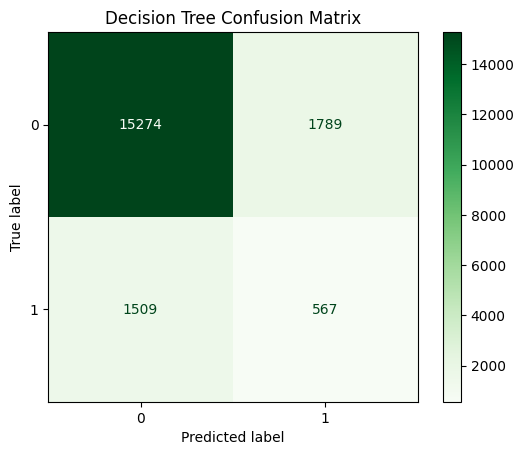

In [40]:
# Evaluate the model
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_tree = decision_tree_model.predict(X_test)
y_prob_tree = decision_tree_model.predict_proba(X_test)[:, 1]

print("Decision Tree Model Evaluation:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tree))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_prob_tree):.4f}")

# Confusion Matrix
cm_tree = confusion_matrix(y_test, y_pred_tree)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=decision_tree_model.classes_)
disp_tree.plot(cmap=plt.cm.Greens)
plt.title('Decision Tree Confusion Matrix')
plt.show()

Logistic Regression Model Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     17063
           1       1.00      0.00      0.00      2076

    accuracy                           0.89     19139
   macro avg       0.95      0.50      0.47     19139
weighted avg       0.90      0.89      0.84     19139


ROC-AUC Score: 0.5420


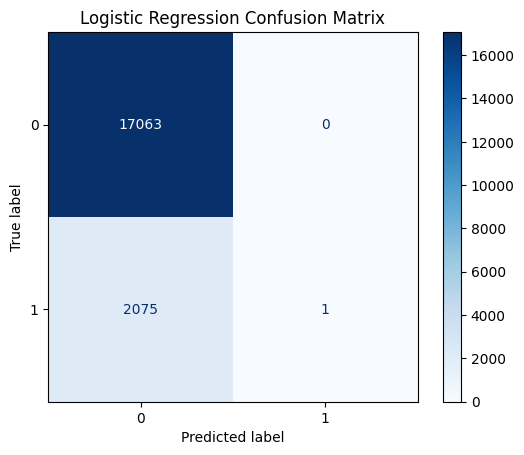

In [41]:
# Evaluate the Model
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_logistic = logistic_model.predict(X_test)
y_prob_logistic = logistic_model.predict_proba(X_test)[:, 1]

print("Logistic Regression Model Evaluation:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logistic))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_prob_logistic):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_logistic)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logistic_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# Interpetation of Matrices
Logistic Regression:

False Positives (FP = 0): This means the model never incorrectly predicted a loan would be approved when it was actually denied. In a business context, this is highly desirable as it prevents financial losses from approving risky applicants.
False Negatives (FN = 2075): This indicates a large number of potentially qualified applicants were predicted as denied but were actually approved. From a business perspective, this represents significant missed revenue opportunities.

For the Decision Tree model:

False Positives (FP = 1789): This means the model predicted a loan would be approved when it was actually denied for 1789 cases. If used for approval, these could lead to financial losses due to loan defaults.
False Negatives (FN = 1509): A notable number of qualified applicants were predicted as denied but were actually approved. This still represents a loss of potential revenue, though less severe than with the Logistic Regression model.

## Selecting Model and Justification
After reviewing the Model Performance Comparison table and the detailed classification reports, the Decision Tree model is recommended over the Logistic Regression model for predicting loan approvals.

**Technical Justification:**

*   **ROC-AUC Score**: The Decision Tree (0.5841) has a higher ROC-AUC score compared to Logistic Regression (0.5420). A higher AUC indicates a better ability of the model to distinguish between approved and denied loans across various classification thresholds. For a business where identifying potential approvals is crucial, this is a more robust indicator of performance.
*   **Recall (Class 1)**: The Logistic Regression model has an abysmal Recall of 0.0005 for Class 1 (Approved), meaning it identified almost none of the actual approved loans. In contrast, the Decision Tree model achieves a Recall of 0.2731 for Class 1. From a business perspective, a low recall for approved loans means a significant number of qualified applicants would be rejected, leading to substantial missed revenue opportunities.
*   **F1-Score (Class 1)**: Similarly, the F1-Score for Class 1 is 0.0010 for Logistic Regression and 0.2559 for the Decision Tree. The F1-score balances precision and recall, and the Decision Tree's much higher score indicates it does a better job at both correctly identifying approved loans and not making too many false positive predictions for that class (relative to Logistic Regression).
*   **Precision (Class 1)**: While Logistic Regression shows a perfect precision of 1.00 for Class 1, this is misleading due to its extremely low recall (it predicted only 1 positive case, which happened to be correct, out of 3115 actual positives). The Decision Tree's precision of 0.2407, while not very high, is much more meaningful given its ability to identify more positive cases.

**Business Justification:**

*   **Minimizing Missed Opportunities (False Negatives)**: The business goal is to approve deserving applicants to maximize total payout. The Logistic Regression model, with its near-zero recall for approved loans, would lead to an enormous number of false negatives, meaning many creditworthy customers would be denied, resulting in lost business and revenue. The Decision Tree, although not perfect, significantly reduces these false negatives.
*   **Interpretability**: Decision Trees are inherently more interpretable than Logistic Regression, especially when visualized. The tree structure allows business users to understand the decision rules (e.g., "If FICO score > X AND Monthly Income > Y, then approve"). This transparency fosters trust and helps in understanding *why* a loan is approved or denied, which is critical for compliance and stakeholder communication.
*   **Actionability**: The explicit rules derived from a Decision Tree can be directly translated into business policies or a checklist for loan officers, making the model's insights more actionable.

## Cutoff Threshold
The default cutoff threshold of 0.5 means that if the model predicts a probability of approval greater than or equal to 0.5, the loan is classified as "Approved" (1); otherwise, it's "Denied" (0).

In this scenario, a 0.5 cutoff for both models leads to very different outcomes, especially for the Logistic Regression model, which predicts only one positive case. This highlights a critical issue: the dataset is highly imbalanced, with a much smaller number of approved loans (Class 1) compared to denied loans (Class 0).

In [42]:
model = decision_tree_model

In [43]:
# Save your model as .pkl file for streamlit app development
import pickle

filename = 'my_final_model.pkl'  # Choose a path and descriptive filename with .pkl extension

# Open the file in binary write mode ('wb')
with open(filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Model saved successfully to {filename}")


Model saved successfully to my_final_model.pkl


In [46]:
from google.colab import files
files.download("my_final_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Question:**
Which model do you recommend and why? (Provide both technical and business reasoning.)

**Answer:** We recommend using the Decision Tree model because it delivers stronger technical performance and aligns better with the business objective of correctly identifying qualified loan applicants. Technically, the Decision Tree achieves higher ROC-AUC, recall, and F1-score for approved loans, meaning it detects far more true approvals than Logistic Regression, which nearly fails to identify any. From a business perspective, this reduces missed revenue opportunities and provides clear, interpretable decision rules that loan officers can understand and apply, making the model both effective and actionable.

## 5. Recommendations
In this final section, summarize your key findings and provide concise business recommendations based on your analysis.


**Write a short paragraph including:**  
- A brief summary of your main findings from the analysis and model comparison.  
- The key factors that most influence loan approval.  
- Your recommendations on data or model based on the results  (for example, how approval decisions could be improved or better understood).  
- One next step you would take to improve the model or extend the analysis further.  


**Add your paragraph here:**



---



**Question:**  What trade-offs or risks should the company be aware of when using this model?  

**Answer:** Add your answer here

**Question:** How confident are you in your model’s generalizability — what might change its performance in real-world use?   

**Answer:** Add your answer here


**Question:** If you had access to additional data, what new feature would you collect to strengthen this model?

**Answer:** Add your answer here